In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/residual/submission.csv
/kaggle/input/residual/solution.csv


## TEAM: THE OUTLIERS
1. Nikita Anup PES2UG22CS361 - SEM V-'F'
2. Princia Dsouza PES2UG22CS416 - SEM V-'G'
3. Rasika Sharma PES2UG22CS435 - SEM V-'H'
4. Parvathi Prakash PES2UG22CS384 - SEM V-'G'

CAMPUS: EC CAMPUS

FACULTY: DR. SUDEEPA ROY DEY



In [2]:
import pandas as pd

# Load the data
soln = pd.read_csv('/kaggle/input/residual/solution.csv')
sub =  pd.read_csv('/kaggle/input/residual/submission.csv')


In [3]:
soln.drop(['Usage'], axis=1, inplace=True)


In [4]:
sub.head()

,timestamp,average_fare_bike,average_fare_auto,average_fare_car
0,2023-05-26 05:00:00,82.866554,41.961845,159.071836
1,2023-05-26 06:00:00,82.011013,41.760265,159.221731
2,2023-05-26 07:00:00,82.336702,40.561050,159.073799
3,2023-05-26 08:00:00,83.006611,41.895370,158.665360
4,2023-05-26 09:00:00,83.764065,43.223534,158.025710


In [5]:

merged_df = pd.merge(soln, sub, on='timestamp', suffixes=('_actual', '_predicted'))


merged_df['residual_bike'] = merged_df['average_fare_bike_actual'] - merged_df['average_fare_bike_predicted']
merged_df['residual_auto'] = merged_df['average_fare_auto_actual'] - merged_df['average_fare_auto_predicted']
merged_df['residual_car'] = merged_df['average_fare_car_actual'] - merged_df['average_fare_car_predicted']

# MODEL JUSTIFICATION:

**Holt-Winters for Car Fare:**
The **Holt-Winters model** is particularly well-suited for **non-stationary** data with clear **seasonality** and **trend components**. In the case of car fares, the seasonal fluctuations in fare prices and the upward trend in prices over time made it an ideal model.


* **Capturing Seasonality**:
   From the seasonal decomposition plots, it was observed that the demand for car fares rise during specific times of the day, on weekends, or in response to other cyclical factors such as holidays or events.
   -Holt-Winters is specifically designed to handle this type of seasonality. The model incorporates seasonal components that can vary in strength, allowing it to capture repeating patterns in car fares that occur at regular intervals (e.g., every day or every week).

* **Model Flexibility with Trends**:
   There is an upward trend observed over time. This indicates that, on average, the fare for cars has been increasing, likely due to inflation, increased demand, or other factors.
   Holt-Winters is capable of adjusting to this trend component. The ability to model a trend in addition to seasonality is crucial in accurately forecasting future car fares that may continue to increase over time.

* **Handling Non-Stationary Data**:
   The car fare data is non-stationary, and cannot be treated as a simple time series with constant mean and variance. The Holt-Winters method is effective for non-stationary data because it decomposes the series into three components: level, trend, and seasonality.
   




**ARIMAX for Bike Fare:**
We chose the ARIMAX model for calculating bike fares for the following reasons: 
1. **Handling Non-Stationarity**:
   The bike fare data exhibits non-stationarity and the ARIMAX model is specifically designed to handle non-stationary time series data by using differencing. This is necessary because many time series models, including ARIMA, assume stationarity for accurate forecasting.

2. **Incorporating Exogenous Variables**:
   In the case of bike fares, we included some exogeneous variables like the number of rides completed, surge multiplier etc. which can directly impact the demand and therefore the price of bike fares.
      These exogenous variables are critical in accurately modeling the bike fare, as they provide additional information beyond just the historical fare values themselves. 

3. **Capturing underylying patterns**:
   In the bike fare data, there is a clear upward trend in the average fare over time, suggesting that bike fares are gradually increasing. 
   The ARIMAX model accounts for this trend by differencing to remove the trend and make the series stationary. By stabilizing the data, the ARIMAX model can effectively forecast future values by focusing on the underlying patterns and not just the noise in the data. Similarly, seasonal components are evident in the data, with consistent peaks and troughs at regular intervals. ARIMAX can capture these seasonal patterns  and learn the cyclical nature of bike fares and improve the accuracy of predictions.

**

**XGBOOST for Auto Fares:**
We decided to use the XGBoost model to predict Auto Fares for the following reasons:

1. **Handling Stationary Data**:
   Auto fare data is stationary. Stationary data is more predictable, and a model like XGBoost is effective in capturing complex patterns and relationships within such data. 

2. **Capturing Complex Relationships**:
   XGBoost excels at capturing intricate relationships within the data by using decision trees. It is particularly useful when there are multiple interacting features (predictors) that can influence the auto fares, such as rides completed, surge multiplier etc.
  

3. **No Clear Trend**:
   In the case of auto fares, there is no clear upward or downward trend in the data. This is evident from the plot, where you do not see a consistent increase or decrease in fares over time. XGBoost is well-suited to this type of data because it does not rely on trend-based transformations (like differencing) and can instead focus on identifying patterns that may exist in the data through tree-based methods.


4. **Inconsistent Troughs and Peaks**:
   The data shows inconsistent peaks and troughs throughout the plot, which suggests that demand for autos can fluctuate based on different factors. Unlike a model that would try to fit a constant trend or seasonality (like Holt-Winters), XGBoost can learn these irregularities and adapt to them, thus making it more flexible in capturing non-linear and complex behaviors.

 5. **Seasonality**: 
While there are no clear trends, the data still exhibits seasonality, especially in demand patterns. For example, bookings tend to drop during the summer, which XGBoost can learn and incorporate as a seasonal factor in its predictions.



In [6]:
from statsmodels.stats.diagnostic import acorr_ljungbox


ljung_box_bike = acorr_ljungbox(merged_df['residual_bike'], lags=[10, 20], return_df=True)
ljung_box_auto = acorr_ljungbox(merged_df['residual_auto'], lags=[10, 20], return_df=True)
ljung_box_car = acorr_ljungbox(merged_df['residual_car'], lags=[10, 20], return_df=True)

print("Ljung-Box Test Results for Bike Residuals:\n", ljung_box_bike)
print("Ljung-Box Test Results for Auto Residuals:\n", ljung_box_auto)
print("Ljung-Box Test Results for Car Residuals:\n", ljung_box_car)


Ljung-Box Test Results for Bike Residuals:
          lb_stat  lb_pvalue
10  46578.268090        0.0
20  89460.778865        0.0
Ljung-Box Test Results for Auto Residuals:
         lb_stat  lb_pvalue
10  5289.153643        0.0
20  5624.486952        0.0
Ljung-Box Test Results for Car Residuals:
          lb_stat  lb_pvalue
10  31672.006931        0.0
20  51895.751317        0.0


**Bike Residuals:**

The test statistic values at lags 10 and 20 are extremely high (46,578.27 and 89,460.78, respectively), and the associated p-values are 0.0.
Since the p-values are below the significance level (0.05), we reject the null hypothesis of no autocorrelation. This suggests that the bike residuals exhibit strong autocorrelation at these lags, indicating unmodeled patterns (trends or seasonality) in the bike fare data.

**Auto Residuals:**

The test statistic values are lower than for bike residuals but still high at lags 10 and 20 (5,289.15 and 5,624.49), with p-values of 0.0.
The p-values indicate significant autocorrelation in the auto residuals as well, suggesting that the model for auto fares also missed some patterns.

**Car Residuals:**

Similar to the bike residuals, the car residuals show very high test statistics (31,672.01 and 51,895.75 at lags 10 and 20) and p-values of 0.0.
The results indicate strong autocorrelation in the car residuals, indicating that this model also failed to capture certain patterns.pendencies.

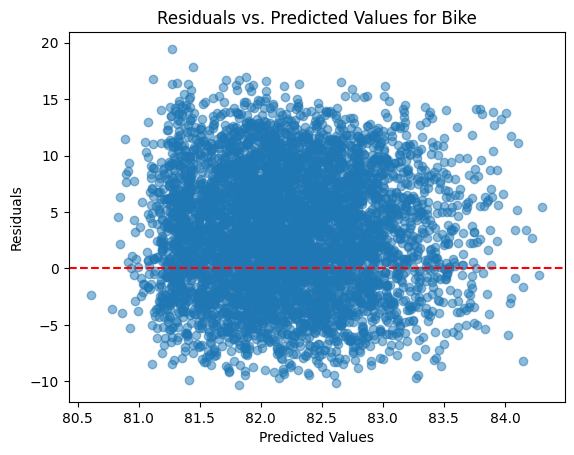

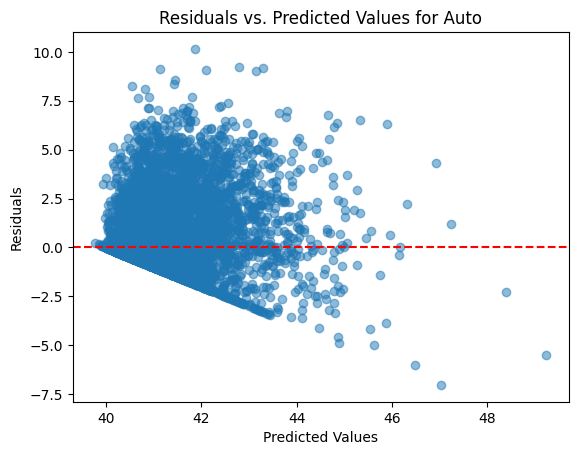

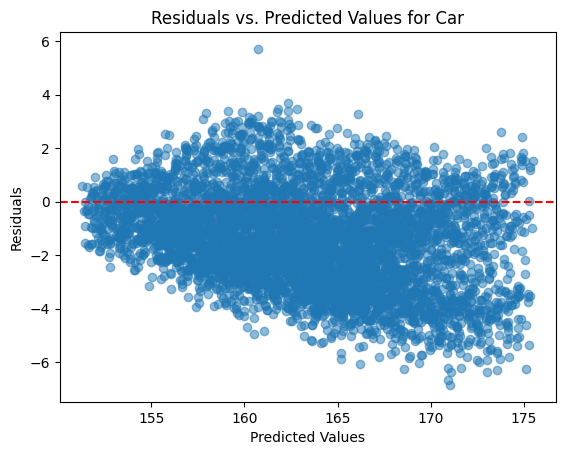

In [7]:
import matplotlib.pyplot as plt


fare_types = ['bike', 'auto', 'car']
for fare in fare_types:
    plt.figure()
    plt.scatter(merged_df[f'average_fare_{fare}_predicted'], merged_df[f'residual_{fare}'], alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'Residuals vs. Predicted Values for {fare.capitalize()}')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.show()


From the plots above, it is observed that,
The residuals of bike clearly show no discernable pattern and are randomly scattered around the red line, which signifies that the model has captured the underlying patterns well.

The residuals for auto however seem to show a pattern concentrating at the lower end of the red line, which indicates that the model might've missed some underlying patterns and is not a perfect fit.

The residuals for car also are mostly randomly scattered albeit a slight funnel shape can be seen.

<Figure size 640x480 with 0 Axes>

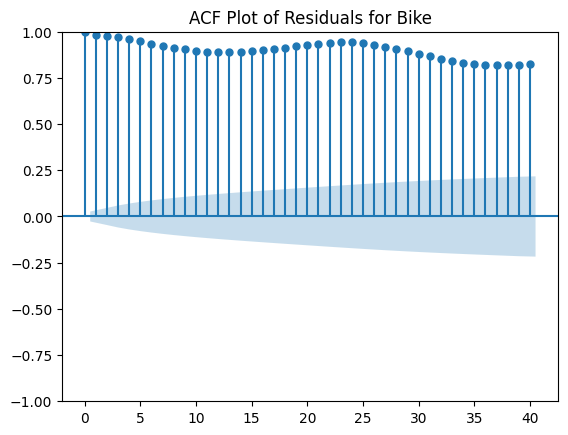

<Figure size 640x480 with 0 Axes>

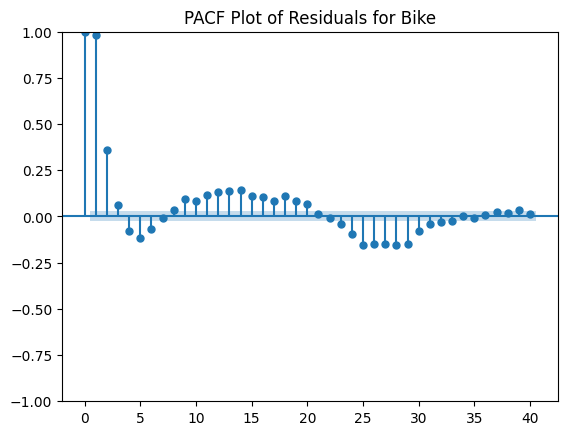

<Figure size 640x480 with 0 Axes>

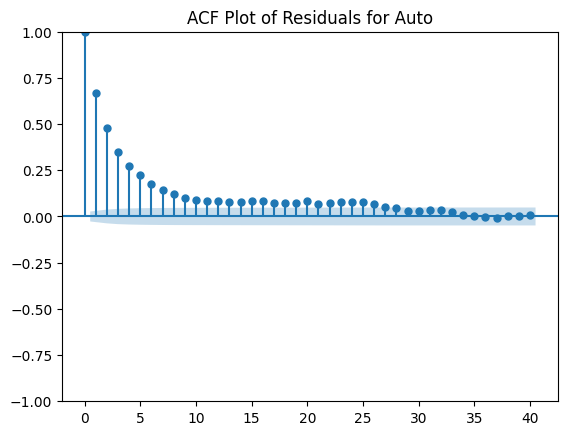

<Figure size 640x480 with 0 Axes>

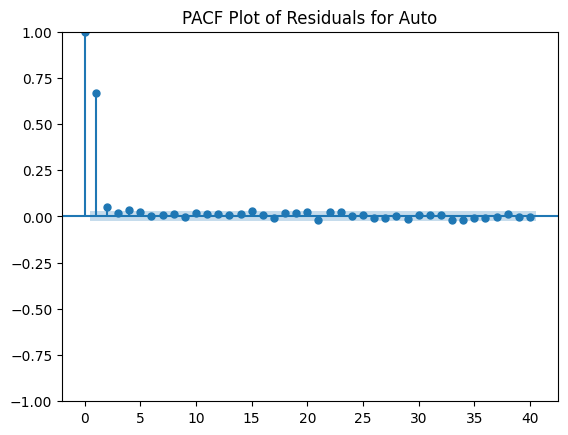

<Figure size 640x480 with 0 Axes>

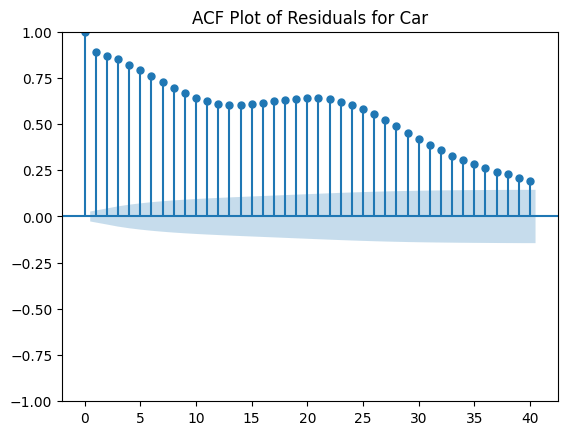

<Figure size 640x480 with 0 Axes>

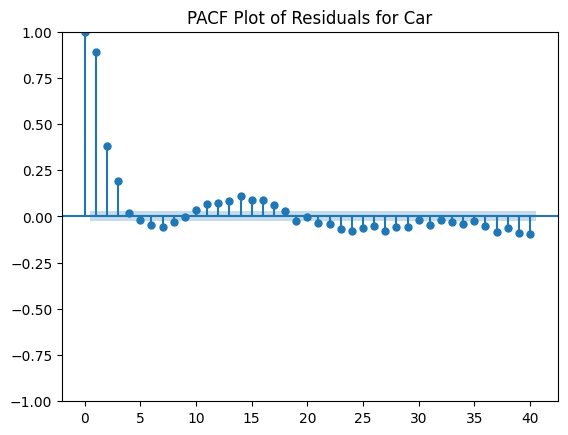

In [8]:
import statsmodels.api as sm

for fare in fare_types:
    plt.figure()
    sm.graphics.tsa.plot_acf(merged_df[f'residual_{fare}'], lags=40)
    plt.title(f'ACF Plot of Residuals for {fare.capitalize()}')
    plt.show()

    plt.figure()
    sm.graphics.tsa.plot_pacf(merged_df[f'residual_{fare}'], lags=40)
    plt.title(f'PACF Plot of Residuals for {fare.capitalize()}')
    plt.show()


**Bike:**

ACF plot:
Residuals exhibit strong autocorrelation across lags, suggesting dependency over time. The model most probably does not fully capture the temporal dynamics of the bike fare data.
Many autocorrelation values exceed the confidence intervals, confirming non-random patterns.

PACF plot: shows significant spikes at the first and second lags, which suggests that there is a relationship between the residuals and specific lags, hence there could be a few patterns the model missed out on.

**Auto**:

ACF plot: shows spike at lag 1, which may indicate that potential patterns have been missed.

PACF plot: shows significant spikes at lag 1 and lag 2,  which suggests that there is a relationship between the residuals and specific lags, hence there could be a few patterns the model missed out on.

**Car**:

ACF plot: The plot is shows a gradually declining pattern, which indicates that potential seasonality or trend components have not been fully captured by our model.

PACF plot: There are significant spikes at lag 1 and lag 2, which suggests that there is a relationship between the residuals and specific lags, hence there could be a few patterns the model missed out on.




<Figure size 640x480 with 0 Axes>

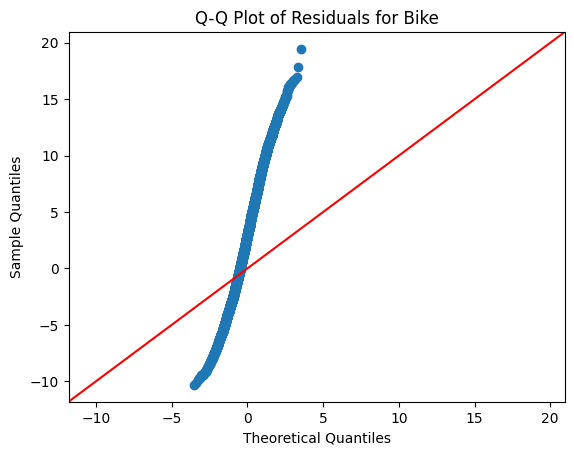

<Figure size 640x480 with 0 Axes>

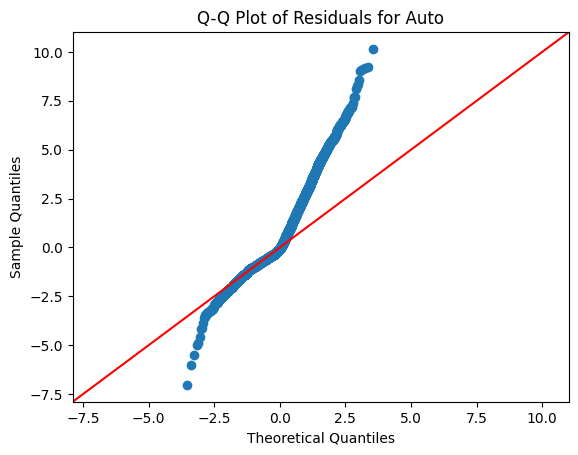

<Figure size 640x480 with 0 Axes>

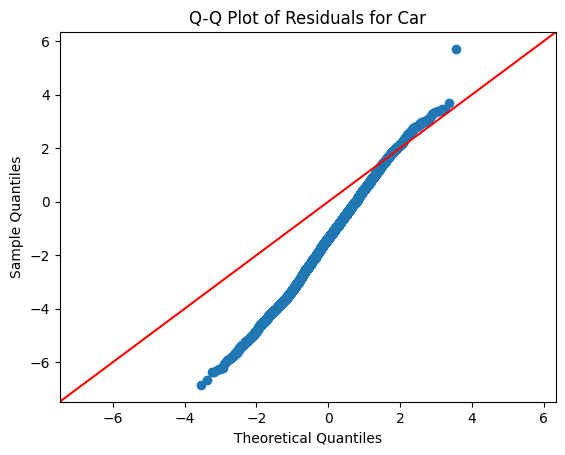

In [9]:
for fare in fare_types:
    plt.figure()
    sm.qqplot(merged_df[f'residual_{fare}'], line='45')
    plt.title(f'Q-Q Plot of Residuals for {fare.capitalize()}')
    plt.show()


Bike Residuals:


* Shows a strong S-shaped curve, indicating significant deviation from normality
* Heavy tails on both ends (especially visible in the upper tail)
* The distribution appears to be skewed right (higher values deviate more)
*This suggests the residuals for bike fares are not normally distributed, which may indicate:

* Possible outliers in higher fare ranges
* Our model might not be capturing some non-linear relationships
* There might be some systematic bias in predictions for bike fares




Auto Residuals:


* Shows a moderate deviation from the diagonal line
* Has a slight S-shape but less pronounced than bike
* Some deviation at both tails, particularly visible in the lower and upper extremes
*This indicates:

* Better normality than bike residuals but still not perfectly normal
* Possible systematic under/over-prediction at extreme values
* Our has Moderate model fit for auto fares




Car Residuals:


* Shows the best fit to the diagonal line among all three
* Minor deviations at the tails
* Most points follow the reference line closely in the middle range
*This suggests:

* Residuals are approximately normally distributed
* Our model performs best for car fares
* Most reliable predictions among the three categories



Overall Implications:

* Our model's performance varies significantly across fare types
* Car fare predictions are most reliable and meet regression assumptions best
* Bike fare predictions may need improvement through:

Adding non-linear terms
Handling outliers
Considering transformation of variables


* Auto fare predictions are moderate in quality and might benefit from some model refinements

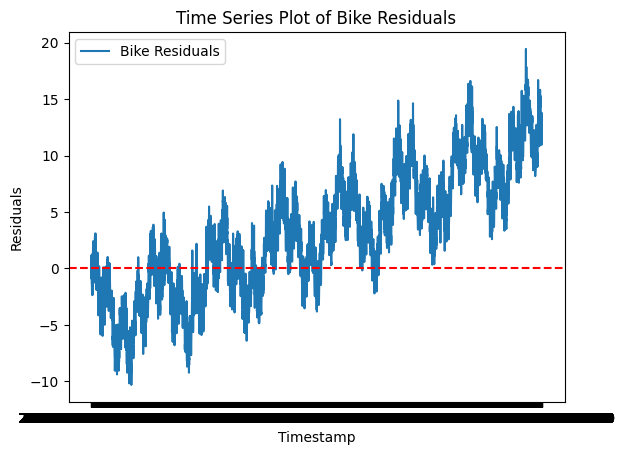

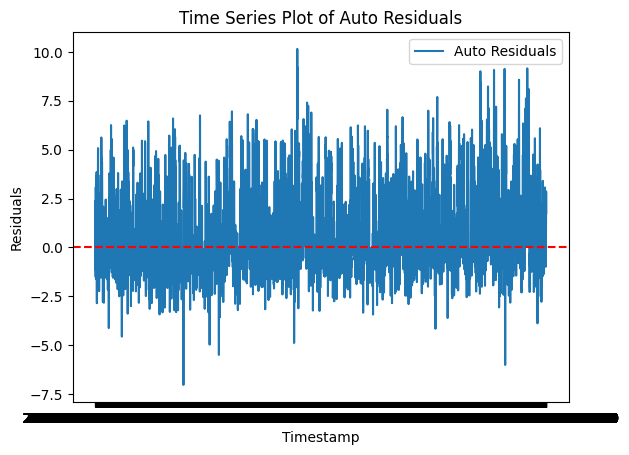

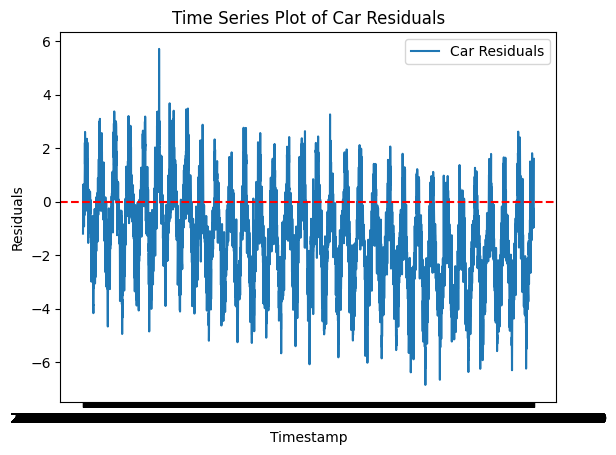

In [10]:
import matplotlib.pyplot as plt

for fare in ['bike', 'auto', 'car']:
    plt.figure()
    plt.plot(merged_df['timestamp'], merged_df[f'residual_{fare}'], label=f'{fare.capitalize()} Residuals')
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'Time Series Plot of {fare.capitalize()} Residuals')
    plt.xlabel('Timestamp')
    plt.ylabel('Residuals')
    plt.legend()
    plt.show()


> Bike Residuals:

* Shows a clear upward trend over time.
* Residuals range from -10 to +15.
* Higher variability in recent periods.
* Suggests systematic underprediction of bike usage over .

> Auto Residuals:

* More symmetric distribution around zero.
* Residuals range from -7.5 to +10.
* Consistent variance throughout.
* Shows regular short-term fluctuations.
* Suggests relatively balanced predictions.

> Car Residuals:

* Shows a slight downward trend.
* Residuals range from -6 to +6.
* Regular cyclical pattern visible.
* Increasing negative bias over time.
* Suggests potential overprediction in recent periods.